In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn.functional as F

In [3]:
words = open('names.txt').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [4]:
# let's only have one special token, and let's have it at index 0, offset others by 1
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
num_classes = len(stoi)

In [5]:
# As we saw before that the network was underfitting
# so we further increase embedding size 2 -> 10

In [6]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((3*10, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]


sum(p.nelement() for p in parameters) # total number of parameters

17697

In [7]:
def build_dataset(words):
    block_size = 3 # How many characters do we take to predict the next one : 3 chars to predict the 4th
    X, Y, = [], [] # X, input | Y, labels

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append moving window

    X = torch.tensor(X)
    Y = torch.tensor(Y)    
    return X, Y

In [8]:
# Splits
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

Xtr.shape, Ytr.shape, Xva.shape, Yva.shape, Xte.shape, Yte.shape

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [9]:
# parameters learnable
for p in parameters:
    p.requires_grad = True

In [10]:
lr = 0.1
steps = 100000

In [11]:
lri = []
lossi = []
losslog10i = []
stepsi = []

In [12]:
tot_steps = len(stepsi)
for i in range(steps):
    # minibatches
    bs = 32
    ix = torch.randint(0, Xtr.shape[0], (bs,))
    
    # forward pass
    emb = C[Xtr[ix]] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, Ytr[ix]) # also Ys have to be at the same index
    if (i+1)%(steps/10) == 0:
        print(f"Iteration {i}: Minibatch loss : {loss.item()}")

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())

Iteration 9999: Minibatch loss : 2.105100393295288
Iteration 19999: Minibatch loss : 3.221322774887085
Iteration 29999: Minibatch loss : 2.640300750732422
Iteration 39999: Minibatch loss : 1.9568108320236206
Iteration 49999: Minibatch loss : 2.408900737762451
Iteration 59999: Minibatch loss : 2.2880911827087402
Iteration 69999: Minibatch loss : 2.275014877319336
Iteration 79999: Minibatch loss : 2.19465708732605
Iteration 89999: Minibatch loss : 2.435854434967041
Iteration 99999: Minibatch loss : 2.2054920196533203


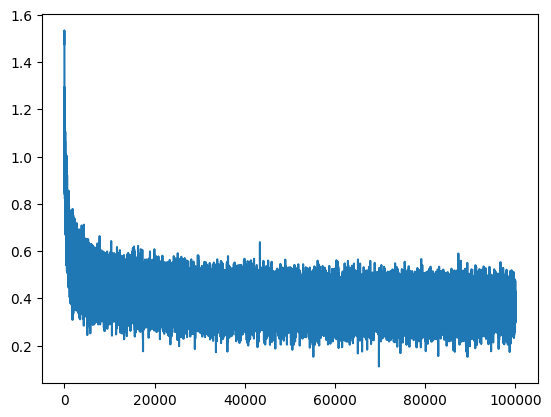

In [13]:
plt.plot(stepsi, losslog10i)

In [14]:
lr = 0.01
steps = 30000

In [15]:
tot_steps = len(stepsi)
for i in range(steps):
    # minibatches
    bs = 32
    ix = torch.randint(0, Xtr.shape[0], (bs,))
    
    # forward pass
    emb = C[Xtr[ix]] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, Ytr[ix]) # also Ys have to be at the same index
    if (i+1)%(steps/10) == 0:
        print(f"Iteration {i}: Minibatch loss : {loss.item()}")

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())

Iteration 2999: Minibatch loss : 1.9128895998001099
Iteration 5999: Minibatch loss : 2.3012173175811768
Iteration 8999: Minibatch loss : 2.1209611892700195
Iteration 11999: Minibatch loss : 2.1343994140625
Iteration 14999: Minibatch loss : 2.218426465988159
Iteration 17999: Minibatch loss : 1.911415696144104
Iteration 20999: Minibatch loss : 2.073284387588501
Iteration 23999: Minibatch loss : 1.6958250999450684
Iteration 26999: Minibatch loss : 2.1915695667266846
Iteration 29999: Minibatch loss : 1.735736608505249


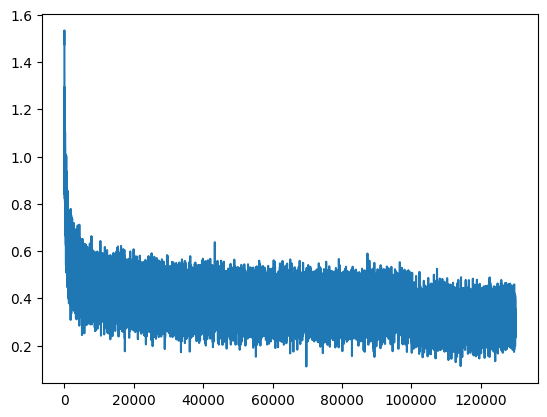

In [16]:
plt.plot(stepsi, losslog10i)

In [17]:
# Let take a look at the losses

In [18]:
# Lets now get Training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1172, grad_fn=<NllLossBackward0>)

In [19]:
# Lets now get Validation loss
emb = C[Xva]
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yva)
loss

tensor(2.1840, grad_fn=<NllLossBackward0>)

In [20]:
# Lets think about sampling now

In [22]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    block_size = 3
    context = [0] * block_size # initialize all with ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1) # exponentiates the logits and then softmaxes them, similar to cross entroy no overflows
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carmahzailyn.
kiferris.
jeany.
salaysie.
mahnen.
deliah.
jareen.
nellara.
chaiir.
kaleigh.
ham.
jocs.
quinn.
sulia.
alianni.
wajero.
dearisi.
jaxen.
dus.
boe.
